![](https://www.nuplan.org/static/media/nuPlan_final.3fde7586.png)

### Contents

1. [Introduction to nuPlan](#introduction)
2. [Training an ML planner](#training)
3. [Simulating a planner](#simulation)
4. [Visualizing metrics and scenarios](#dashboard)

# Introduction to nuPlan <a name="introduction"></a>


Welcome to nuPlan! This notebook will explore the nuPlan simulation framework, training platform as well as the nuBoard metrics/scenarios visualization dashboard.

## What is nuPlan

nuPlan is the world’s first closed-loop ML-based planning benchmark for autonomous driving.

It provides a high quality dataset with 1500h of human driving data from 4 cities across the US and Asia with widely varying traffic patterns (Boston, Pittsburgh, Las Vegas and Singapore). In addition, it provides a closed-loop simulation framework with reactive agents, a training platform as well as a large set of both general and scenario-specific planning metrics.

![](https://www.nuscenes.org/static/media/framework_steps.2d4642df.png)

## Training & simulation framework

The nuPlan training and simulation framework aims to:
* create a simulation pipeline to evaluate a planner on large dataset with various scenarios
* score planner performance with common and scenario-dependent metrics
* compare planners based on measured metrics and provide intuitive visualizations
* train planners with the provided framework to allow quick implementation and iteration
* support closed-loop simulation and training

<br />

![](https://www.nuplan.org/static/media/planning_framework.ca3c2969.png)

## Scenarios in nuPlan

nuPlan aims to capture challenging yet representative scenarios from real-world encounters. This enables the benchmarking of planning systems both in expert imitation (open-loop) and reactive planning (closed-loop) settings.

These scenarios includes:
* highly interactive scenes with traffic participants (e.g. tailgating, high-velocity overtakes, double parked cars, jaywalking)
* various ego behaviors (e.g. vehicle following, yielding, lane merging) and dynamics (e.g. mixed speed profiles, abrupt braking, speed bumps, high jerk maneuvers)
* scene layouts of varied complexity (e.g. pudos, traffic/stop controlled intersections, unprotected turns) and temporary zones (e.g. construction areas)

The dataset is automatically tagged with scenario labels based on certain primitive attributes.
These scenario tags can then be used to extract representative metrics for the planner's evaluation.

Example mined scenarios in nuPlan:

| | | |
| :-: | :-: | :-: |
| Unprotected cross turn | Dense vehicle interactions | Jaywalker in front |
| ![](https://www.nuscenes.org/static/media/unprotected-cross.51feef7e.webp) | ![](https://www.nuscenes.org/static/media/dense-interactions.16de47ec.webp) | ![](https://www.nuscenes.org/static/media/jaywalker.03083823.webp) |
| Lane change | Ego at pickup/dropoff area | Ego following vehicle |
| ![](https://www.nuscenes.org/static/media/lane-change.54bfca1c.webp) | ![](https://www.nuscenes.org/static/media/pickup-dropoff.4dd1c418.webp) | ![](https://www.nuscenes.org/static/media/following-vehicle.4cacd559.webp) |

## Database

Download a database for training/simulation from [here](https://nuplan.org/nuplan#download).

| Database | Size | Duration | Num Logs | Cities | Num Scenarios | Sensor Data | Description |
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| nuplan_v1.1_mini (recommended) | 13GB | 7h | 64 | Las Vegas, Boston, Pittsburgh, Singapore | 67 | N/A | The mini split used for prototyping and testing |
| nuplan_v1.1 | 1.8TB | ~1300h | 15910 | Las Vegas, Boston, Pittsburgh, Singapore | 73 | N/A | The full dataset for training and evaluation|

## Setup

To be able to access all resources within this notebook, make sure Jupyter is launched at the root of this repo. The path of the notebook should be `/notebook/<repo_root>`.

In [1]:
# (Optional) Increase notebook width for all embedded cells to display properly
from IPython.core.display import display, HTML
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_60646/4180358289.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

# Training an ML planner <a name="training"></a>

## Imitation learning
In the following section we will train an ML planning policy with the aim estimate the ego's future trajectory and control the vehicle.

The policy is learned through imitation learning, a supervised learning approach in which - in the context of autonomous driving - the behavior of an expert human driver is used as a target signal to supervise the model.

## Model features & targets
A planning policy consumes a set of episodic observations and encodes them through a deep neural network to regress a future trajectory.

The observations can be historic or present ego and agent poses as well as static/dynamic map information across different map layers.<br />
These signals can be encoded through various representations, such as raster or vector format for the map signal, each with their pros and cons for each model flavor.

Using these input features the model predicts a discretized future trajectory across a fixed time horizon.<br />
The trajectory consists of a set of discrete future states (position, heading and velocity) sampled at fixed intervals which express the likelihood of the vehicle being at that state in the future.<br />
For example, a predicted trajectory may consist of 10 future poses sampled at intervals of 0.5s across a 5s horizon.

## Learning objectives
The policy is trained to maximize a set of aggregated objectives such as imitation, collision avoidance, traffic rule violation etc.<br />
Imitation is the core training objective which indicates how close the predicted trajectory is to the expert ground truth and penalizes model predictions that deviate in space and time from the demonstration.

## Training parameters

The following parameter categories define the training protocol which includes the model, metrics, objectives etc.

A working example composition of these parameters can be found in the next section.

---

### ML models

Change the training model with `model=X` where `X` is a config yaml defined in the table below. 

| Model | Description | Config |
| --- | --- | --- |
| Raster model (CNN) | Raster-based model that uses a CNN backbone to encode ego, agent and map information as raster layers<br />Any (pretrained) backbone from the TIMM library can be used (e.g. ResNet50, EfficientNetB3) | `raster_model` |
| Vector model (LaneGCN) | Vector-based model that uses a series of MLPs to encode ego and agent signals, a lane graph to encode vector-map elements and a fusion network to capture lane & agent intra/inter-interactions through attention layers<br />Implementation of LaneGCN paper ("Learning Lane Graph Representations for Motion Forecasting") | `vector_model` |
| Simple vector model | Toy vector-based model that consumes ego, agent and lane signals through a series of MLPs | `simple_vector_model` |

<br />

### Training objectives

Change the training objectives with `objective=[X, ...]` where `X` is a config yaml defined in the table below. 

| Objective | Description | Config |
| --- | --- | --- |
| Imitation objective | Penalizes the predicted trajectory that deviates from the expert demonstration | `imitation_objective` |

<br />

### Training metrics

Change the training objectives with `training_metric=[X, ...]` where `X` is a config yaml defined in the table below. 

| Metric | Description | Config |
| --- | --- | --- |
| Average displacement error | RMSE translation error across full predicted trajectory | `avg_displacement_error` |
| Average heading error | RMSE heading error across full predicted trajectory | `avg_heading_error` |
| Final displacement error | L2 error of predicted trajectory's final pose translation | `final_displacement_error` |
| Final heading error | L2 error of predicted trajectory's final pose heading | `final_heading_error` |

## Prepare the training config

In [4]:
# Location of path with all training configs
CONFIG_PATH = '../nuplan/planning/script/config/training'
CONFIG_NAME = 'default_training'

# Create a temporary directory to store the cache and experiment artifacts
# SAVE_DIR = Path(tempfile.gettempdir()) / 'tutorial_nuplan_framework'  # optionally replace with persistent dir
SAVE_DIR = Path('/hdd/vladislav/nuplan-results')
EXPERIMENT = 'training_raster_experiment'
JOB_NAME = 'train_default_raster'
LOG_DIR = str(SAVE_DIR / EXPERIMENT / JOB_NAME)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'group={str(SAVE_DIR)}',
    f'cache.cache_path={str(SAVE_DIR)}/cache',
    f'experiment_name={EXPERIMENT}',
    f'job_name={JOB_NAME}',
    'py_func=train',
    '+training=training_raster_model',  # raster model that consumes ego, agents and map raster layers and regresses the ego's trajectory
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter.limit_total_scenarios=500',  # Choose 500 scenarios to train with
    'lightning.trainer.params.accelerator=ddp_spawn',  # ddp is not allowed in interactive environment, using ddp_spawn instead - this can bottleneck the data pipeline, it is recommended to run training outside the notebook
    'lightning.trainer.params.max_epochs=10',
    'data_loader.params.batch_size=8',
    'data_loader.params.num_workers=8',
])


## Launch tensorboard for visualizing training artifacts

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {LOG_DIR}

## Launch training (within the notebook)

In [ ]:
from nuplan.planning.script.run_training import main as main_train

# Run the training loop, optionally inspect training artifacts through tensorboard (above cell)
main_train(cfg)

## Launch training (command line - alternative)

A training experiment with the above same parameters can be launched alternatively with:
```
$ python nuplan/planning/script/run_training.py \
    experiment_name=raster_experiment \
    py_func=train \
    +training=training_raster_model \
    scenario_builder=nuplan_mini \
    scenario_filter.limit_total_scenarios=500 \
    lightning.trainer.params.max_epochs=10 \
    data_loader.params.batch_size=8 \
    data_loader.params.num_workers=8
```

# Simulating a planner <a name="simulation"></a>

## Open-loop simulation
Open-loop simulation aims to evaluate the policy's capabilities to imitate the expert driver's behavior.<br />
This is essentially done through log replay as the policy's predictions do not affect the state of the simulation.

As the policy is not in full control of the vehicle, this type of simulation can only provide a high-level performance overview.

## Closed-loop simulation
Conversely, in closed-loop simulation the policy's actions alter the state of the simulation which tries to closely approximate the real-world system.

The simulation's feedback loop enables a more in-depth evaluation of the policy as compounding errors can cause future observations to significantly diverge from the ground truth.<br />
This is important in measuring distribution shifts introduced due to lack of variance in training examples through pure imitation learning.

Closed-loop simulation is further divided into two categories:
* ego closed-loop simulation with agents replayed from log (open-loop, non reactive)
* ego closed-loop simulation with agents controlled by a rule-based or learned policy (closed-loop, reactive)

## Measuring success
Measuring the success of a planning task and comparing various planning policies is a complicated effort that involves defining metrics across different vertical dimensions and scenario categories.<br />
These metrics include indicators such as vehicle dynamics, traffic rule violations, expert imitation, navigation success etc.<br />
Overall, they aim to capture the policy's ability to control the autonomous vehicle safely yet efficiently without compromising the passenger's comfort.

## Simulation parameters

### Planners

Change the planner model with `planner=X` where `X` is a config yaml defined in the table below. 

| Planner | Description | Config |
| --- | --- | --- |
| Simple Planner | Naive planner that only plans a straight path | `simple_planner` |
| ML Planner | Learning-based planner trained using the nuPlan training framework (see previous section) | `ml_planner` |

## Prepare the simulation config

In [5]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Select the planner and simulation challenge
PLANNER = 'idm_planner' #'simple_planner'  # [simple_planner, ml_planner]
CHALLENGE = 'open_loop_boxes'  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter=all_scenarios',  # initially select all scenarios in the database
    'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=10',  # use 10 scenarios per scenario type
]

# Name of the experiment
EXPERIMENT = 'simulation_simple_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    f'planner={PLANNER}',
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

## Launch simulation (within the notebook)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-03-26 02:02:54,288 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-03-26 02:02:54,401 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:75}  Starting ray local!


2023-03-26 02:02:56,285	INFO worker.py:1553 -- Started a local Ray instance.


2023-03-26 02:02:57,208 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-03-26 02:02:57,209 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 12
Number of GPUs per node: 1
Number of threads across all nodes: 12
2023-03-26 02:02:57,209 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-03-26 02:02:57,209 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:29}  Building experiment folders...
2023-03-26 02:02:57,209 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  

	Folder where all results are stored: /hdd/vladislav/nuplan-results/simulation_simple_experiment/open_loop_boxes/2023.03.26.02.02.53

2023-03-26 02:02:57,210 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builde

Ray objects: 100%|███████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.08it/s]


2023-03-26 02:03:03,135 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:55}  Extracting scenarios 31...DONE!
2023-03-26 02:03:03,136 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:59}  Building metric engines...
2023-03-26 02:03:03,217 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:61}  Building metric engines...DONE
2023-03-26 02:03:03,217 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:65}  Building simulations from 31 scenarios...
2023-03-26 02:03:03,835 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:121}  Building simulations...DONE!
2023-03-26 02:03:03,835 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Running simulation...
2023-03-26 02:03:03,835 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:135}  Executing runners...
202

Ray objects:   0%|                                                                | 0/31 [00:00<?, ?it/s](raylet) [2023-03-26 02:03:06,181 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857945088; capacity: 490577010688. Object creation will fail if spilling is required.
(wrapped_fn pid=61529) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(wrapped_fn pid=61529) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=61529)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
(wrapped_fn pid=61528) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=61528)   return elements.iloc[

(wrapped_fn pid=61533) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=61533)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Ray objects:  52%|████████████████████████████▍                          | 16/31 [00:46<00:37,  2.51s/it](wrapped_fn pid=62163) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(wrapped_fn pid=62163) /hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
(wrapped_fn pid=62163)   return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
(wrapped_fn pid=61532) WARNING:nuplan.planning.simulation.planner.idm_planner:IDMPlanner could not find valid path to the target roadblock. Using longest route found instead
(rayl

2023-03-26 02:04:23,035 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 31
2023-03-26 02:04:23,039 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-03-26 02:04:23,039 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:144}  Finished executing runners!
2023-03-26 02:04:23,074 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:71}  Saved runner reports to /hdd/vladislav/nuplan-results/simulation_simple_experiment/open_loop_boxes/2023.03.26.02.02.53/runner_report.parquet
2023-03-26 02:04:23,074 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:01:28 [HH:MM:SS]
2023-03-26 02:04:23,411 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:70}  Metric files integration: 00:00:00 [HH:MM:SS]
2023-03-2

Rendering histograms: 100%|████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.49it/s]


2023-03-26 02:04:26,147 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:339}  Metric summary: 00:00:02 [HH:MM:SS]
2023-03-26 02:04:26,148 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/run_simulation.py:82}  Finished running simulation!


(raylet) [2023-03-26 02:04:26,221 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857613312; capacity: 490577010688. Object creation will fail if spilling is required.


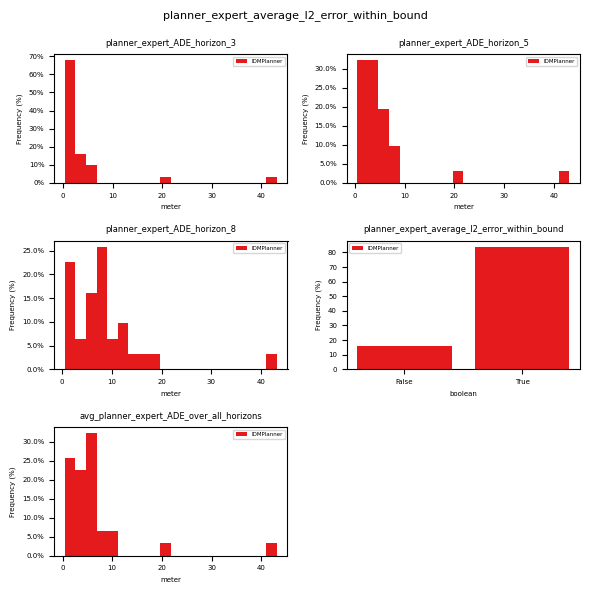

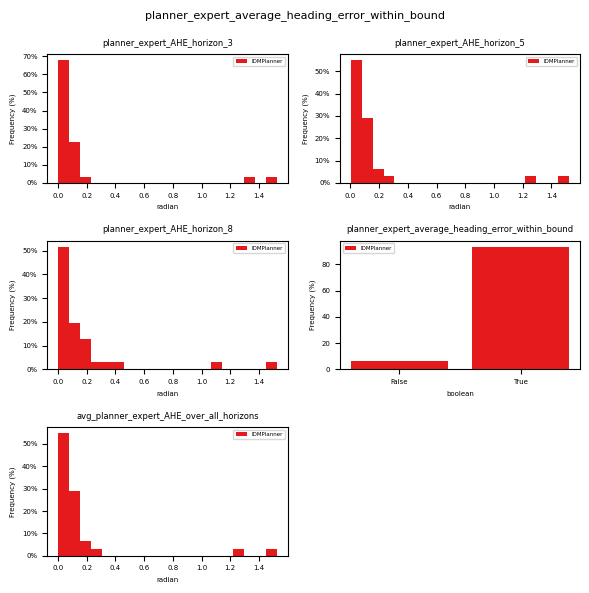

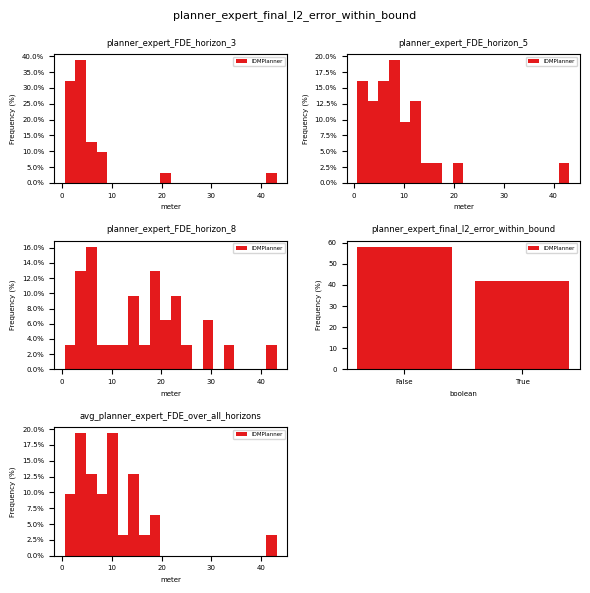

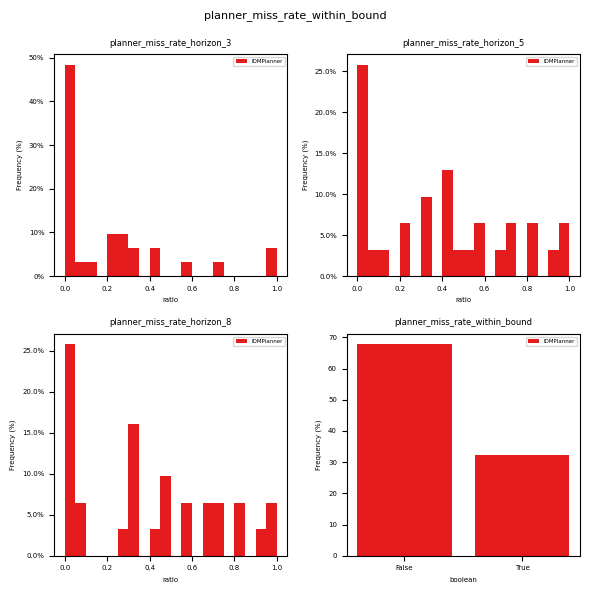

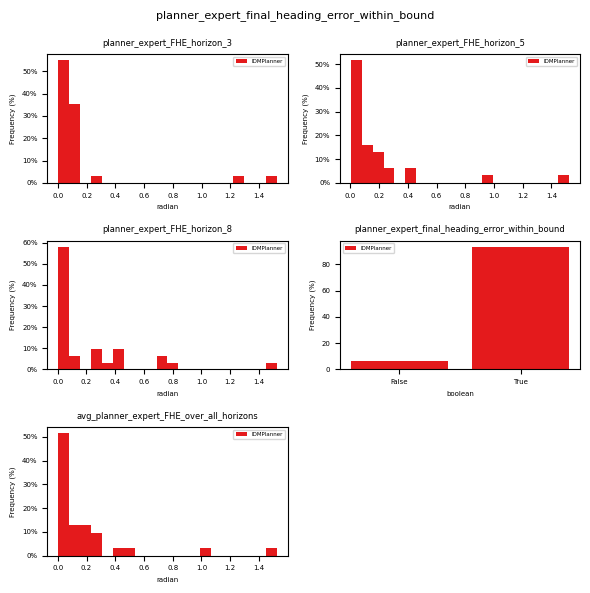

(raylet) [2023-03-26 02:04:36,227 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857539584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:04:46,235 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857564160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:04:56,184 E 61433 61433] (raylet) node_manager.cc:3040: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 2d420524e75bc9b9dba3b4e932a665246647b7a5dbe87c215c6e7d5d, IP: 192.168.0.128) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.0.128`
(raylet) 
(raylet) Refer to the documentation on how to address the out of me

(raylet) [2023-03-26 02:09:06,423 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6848692224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:09:16,430 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6848688128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:09:26,437 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6848688128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:09:36,445 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6848688128; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:14:16,653 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6848278528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:14:26,661 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6848274432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:14:36,668 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6848270336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:14:46,675 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6848253952; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:19:26,882 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847877120; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:19:36,889 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847873024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:19:46,896 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847873024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:19:56,904 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847848448; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:24:37,108 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847528960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:24:47,115 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847524864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:24:57,122 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847488000; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:25:07,130 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847455232; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:29:47,318 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847180800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:29:57,325 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847139840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:30:07,330 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847135744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:30:17,337 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6847131648; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:34:57,523 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6846767104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:35:07,530 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6846767104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:35:17,537 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6846767104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:35:27,545 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6846763008; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:40:07,739 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6846234624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:40:17,746 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6846230528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:40:27,753 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6846226432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:40:37,760 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6846222336; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:45:17,962 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845845504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:45:27,969 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845845504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:45:37,978 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845841408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:45:47,986 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845837312; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:50:28,194 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845534208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:50:38,202 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845521920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:50:48,209 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845517824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:50:58,217 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845464576; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 02:55:38,423 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845177856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:55:48,430 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845177856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:55:58,437 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845128704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 02:56:08,445 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845128704; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:00:48,635 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844846080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:00:58,642 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844813312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:01:08,650 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844809216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:01:18,657 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844809216; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:05:58,867 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844461056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:06:08,876 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844461056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:06:18,884 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844456960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:06:28,891 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844456960; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:11:09,092 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844108800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:11:19,098 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844108800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:11:29,106 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844104704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:11:39,113 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844100608; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:16:19,322 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843805696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:16:29,330 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843801600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:16:39,337 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843797504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:16:49,344 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843797504; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:21:29,554 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843441152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:21:39,562 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843432960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:21:49,569 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843432960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:21:59,576 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843396096; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:26:39,779 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843076608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:26:49,786 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843076608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:26:59,793 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843039744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:27:09,801 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843039744; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:31:50,015 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842773504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:32:00,021 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842724352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:32:10,028 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842724352; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:32:20,034 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842720256; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:37:00,237 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842339328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:37:10,244 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842335232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:37:20,252 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842335232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:37:30,259 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842322944; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:42:10,476 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842032128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:42:20,483 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842028032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:42:30,490 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842015744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:42:40,498 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6842003456; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:47:20,713 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841671680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:47:30,719 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841667584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:47:40,726 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841679872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:47:50,732 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841675776; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:52:30,935 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841327616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:52:40,942 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841319424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:52:50,949 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841319424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:53:00,957 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841298944; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 03:57:41,181 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841016320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:57:51,189 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6841012224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:58:01,197 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6840954880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 03:58:11,205 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6840950784; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:02:51,401 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6840692736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:03:01,407 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6840639488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:03:11,414 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6840639488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:03:21,422 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6840635392; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:08:01,634 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845644800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:08:11,641 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845644800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:08:21,649 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845644800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:08:31,656 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845640704; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:13:11,869 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845222912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:13:21,877 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845222912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:13:31,885 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845218816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:13:41,893 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6845214720; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:18:22,083 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844878848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:18:32,089 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844878848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:18:42,096 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844870656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:18:52,102 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6844866560; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:23:32,280 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843842560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:23:42,289 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843838464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:23:52,297 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843838464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:24:02,304 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6843772928; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:28:42,484 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6838566912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:28:52,491 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6838566912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:29:02,498 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6838521856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:29:12,504 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6838530048; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:33:52,687 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6838210560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:34:02,694 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6838177792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:34:12,701 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6838165504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:34:22,708 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6838165504; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:39:02,910 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837796864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:39:12,917 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837776384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:39:22,924 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837772288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:39:32,931 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837772288; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:44:13,145 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837428224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:44:23,152 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837428224; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:44:33,160 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837424128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:44:43,168 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837420032; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:49:23,363 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837174272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:49:33,371 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837174272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:49:43,379 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837166080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:49:53,387 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6837166080; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:54:33,615 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836817920; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:54:43,623 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836809728; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:54:53,630 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836805632; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:55:03,637 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836764672; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 04:59:43,824 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836453376; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 04:59:53,831 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836453376; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:00:03,838 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836428800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:00:13,844 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836424704; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:04:54,066 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836129792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:05:04,074 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836080640; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:05:14,081 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836076544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:05:24,089 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6836076544; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:10:04,303 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835757056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:10:14,310 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835744768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:10:24,318 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835740672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:10:34,325 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835740672; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:15:14,540 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835433472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:15:24,547 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835425280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:15:34,554 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835421184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:15:44,561 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835421184; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:20:24,798 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835101696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:20:34,806 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835097600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:20:44,814 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835089408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:20:54,822 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6835089408; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:25:35,036 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834712576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:25:45,042 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834708480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:25:55,048 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834704384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:26:05,055 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834679808; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:30:45,235 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834380800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:30:55,241 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834372608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:31:05,247 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834311168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:31:15,253 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834311168; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:35:55,457 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6834024448; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:36:05,464 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833963008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:36:15,472 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833963008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:36:25,480 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833963008; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:41:05,678 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833659904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:41:15,685 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833655808; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:41:25,691 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833651712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:41:35,697 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833647616; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:46:15,921 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833324032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:46:25,929 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833319936; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:46:35,937 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833315840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:46:45,945 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6833307648; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:51:26,161 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832988160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:51:36,169 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832984064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:51:46,176 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832984064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:51:56,184 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832971776; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 05:56:36,397 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832660480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:56:46,405 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832652288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:56:56,413 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832648192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 05:57:06,420 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832582656; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:01:46,628 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832300032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:01:56,635 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832275456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:02:06,643 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832234496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:02:16,651 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6832230400; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:06:56,862 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6751453184; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:07:06,869 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857461760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:07:16,876 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857457664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:07:26,884 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857453568; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:12:07,089 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857101312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:12:17,096 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857101312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:12:27,103 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857101312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:12:37,110 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6857097216; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:17:17,304 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6856757248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:17:27,310 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6856757248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:17:37,317 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6856753152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:17:47,323 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6856749056; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:22:27,515 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6750380032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:22:37,523 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6750367744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:22:47,530 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6750363648; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:22:57,537 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6750334976; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:27:37,741 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6750027776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:27:47,748 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6750027776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:27:57,755 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749966336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:28:07,763 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749974528; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:32:47,968 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749700096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:32:57,976 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749663232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:33:07,983 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749671424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:33:17,991 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749671424; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:37:58,204 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749331456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:38:08,211 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749331456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:38:18,218 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749327360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:38:28,226 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6749327360; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:43:08,435 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748983296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:43:18,442 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748983296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:43:28,450 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748979200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:43:38,457 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748971008; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:48:18,646 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748667904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:48:28,653 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748667904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:48:38,659 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748655616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:48:48,665 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748655616; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:53:28,850 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748295168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:53:38,858 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748295168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:53:48,865 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748291072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:53:58,872 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6748229632; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 06:58:39,075 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747942912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:58:49,082 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747942912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:58:59,090 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747910144; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 06:59:09,097 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747906048; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:03:49,304 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747635712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:03:59,311 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747590656; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:04:09,319 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747586560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:04:19,326 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747574272; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:08:59,543 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747172864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:09:09,550 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747164672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:09:19,557 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747176960; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:09:29,566 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6747176960; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:14:09,779 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746914816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:14:19,787 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746914816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:14:29,794 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746910720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:14:39,801 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746898432; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:19:19,994 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746550272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:19:30,001 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746550272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:19:40,009 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746546176; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:19:50,016 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746546176; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:24:30,231 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746189824; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:24:40,239 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746177536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:24:50,246 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746173440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:25:00,254 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6746144768; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:29:40,466 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745862144; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:29:50,474 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745858048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:30:00,481 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745817088; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:30:10,489 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745817088; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:34:50,706 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745526272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:35:00,713 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745460736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:35:10,720 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745460736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:35:20,727 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745456640; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:40:00,928 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745120768; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:40:10,936 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745112576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:40:20,944 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745100288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:40:30,951 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6745096192; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:45:11,169 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744776704; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:45:21,177 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744772608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:45:31,185 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744772608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:45:41,193 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744768512; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:50:21,401 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744449024; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:50:31,408 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744444928; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:50:41,416 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744440832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:50:51,423 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744436736; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 07:55:31,624 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744100864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:55:41,631 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744092672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:55:51,639 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744088576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 07:56:01,646 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6744047616; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:00:41,833 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743785472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:00:51,840 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743785472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:01:01,846 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743724032; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:01:11,853 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743719936; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:05:52,050 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743433216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:06:02,057 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743388160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:06:12,064 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743388160; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:06:22,072 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743384064; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:11:02,272 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743023616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:11:12,278 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743023616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:11:22,285 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743023616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:11:32,292 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6743007232; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:16:12,516 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742679552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:16:22,524 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742675456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:16:32,531 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742675456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:16:42,539 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742675456; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:21:22,754 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742347776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:21:32,762 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742347776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:21:42,769 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742360064; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:21:52,778 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742355968; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:26:32,995 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742036480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:26:43,003 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742028288; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:26:53,011 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6742024192; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:27:03,018 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741958656; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:31:43,228 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741708800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:31:53,235 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741708800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:32:03,241 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741651456; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:32:13,248 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741651456; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:36:53,447 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741356544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:37:03,454 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741315584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:37:13,461 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741315584; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:37:23,468 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6741311488; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:42:03,672 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740946944; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:42:13,677 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740946944; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:42:23,684 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740926464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:42:33,691 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740922368; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:47:13,905 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740611072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:47:23,913 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740611072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:47:33,921 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740606976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:47:43,928 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740606976; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:52:24,117 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740295680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:52:34,124 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740275200; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:52:44,130 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740262912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:52:54,136 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6740262912; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 08:57:34,338 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739939328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:57:44,345 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739939328; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:57:54,352 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739935232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 08:58:04,358 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739881984; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:02:44,581 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739578880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:02:54,588 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739578880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:03:04,595 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739542016; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:03:14,603 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739537920; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:07:54,819 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739238912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:08:04,827 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739185664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:08:14,835 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739181568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:08:24,842 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6739181568; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:13:05,049 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738849792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:13:15,058 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738849792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:13:25,065 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738845696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:13:35,074 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738841600; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:18:15,289 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738534400; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:18:25,297 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738530304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:18:35,305 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738530304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:18:45,312 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738522112; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:23:25,509 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738198528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:23:35,516 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738186240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:23:45,522 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738186240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:23:55,529 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6738182144; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:28:35,739 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737850368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:28:45,747 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737846272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:28:55,754 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737829888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:29:05,762 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737772544; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:33:45,954 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737514496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:33:55,961 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737506304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:34:05,967 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737457152; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:34:15,974 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737444864; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:38:56,182 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737162240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:39:06,190 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737100800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:39:16,198 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737113088; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:39:26,205 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6737113088; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:44:06,420 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736781312; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:44:16,427 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736777216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:44:26,435 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736777216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:44:36,442 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736781312; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:49:16,655 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736412672; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:49:26,663 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736408576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:49:36,669 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736420864; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:49:46,677 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736416768; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:54:26,873 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736089088; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:54:36,880 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736080896; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:54:46,888 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736076800; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:54:56,896 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6736068608; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 09:59:37,106 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6735556608; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:59:47,114 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6735552512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 09:59:57,121 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6735527936; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:00:07,129 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6735495168; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:04:47,329 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6735212544; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:04:57,337 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6735183872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:05:07,345 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6735147008; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:05:17,352 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6735142912; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:09:57,557 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6729486336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:10:07,564 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6729474048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:10:17,571 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6729457664; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:10:27,578 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6729453568; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:15:07,783 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6729125888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:15:17,791 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6729125888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:15:27,799 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6729125888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:15:37,806 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6729121792; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:20:17,989 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728765440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:20:27,995 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728761344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:20:38,001 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728761344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:20:48,008 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728753152; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:25:28,208 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728429568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:25:38,216 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728425472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:25:48,224 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728425472; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:25:58,231 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728400896; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:30:38,440 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728085504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:30:48,447 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728085504; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:30:58,455 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728060928; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:31:08,462 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6728019968; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:35:48,665 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6727733248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:35:58,672 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6727704576; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:36:08,679 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6727684096; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:36:18,686 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6727684096; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:40:58,892 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6727344128; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:41:08,899 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6727331840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:41:18,905 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6727327744; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:41:28,913 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6727327744; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:46:09,114 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726991872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:46:19,121 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726991872; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:46:29,128 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726987776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:46:39,135 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726983680; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:51:19,352 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726639616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:51:29,360 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726639616; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:51:39,367 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726631424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:51:49,374 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726631424; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 10:56:29,581 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726311936; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:56:39,589 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726307840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:56:49,597 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726295552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 10:56:59,604 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6726234112; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:01:39,801 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725963776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:01:49,808 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725963776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:01:59,815 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725926912; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:02:09,822 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725926912; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:06:50,034 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725591040; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:07:00,042 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725562368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:07:10,050 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725558272; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:07:20,058 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725554176; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:12:00,271 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725242880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:12:10,279 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725242880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:12:20,287 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725238784; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:12:30,295 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6725226496; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:17:10,508 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724911104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:17:20,516 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724911104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:17:30,524 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724894720; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:17:40,532 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724894720; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:22:20,745 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724595712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:22:30,752 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724583424; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:22:40,760 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724571136; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:22:50,767 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724571136; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:27:30,976 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724231168; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:27:40,983 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724227072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:27:50,991 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724227072; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:28:00,998 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6724194304; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:32:41,212 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723915776; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:32:51,220 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723911680; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:33:01,228 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723874816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:33:11,236 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723862528; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:37:51,451 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723584000; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:38:01,459 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723530752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:38:11,467 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723530752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:38:21,474 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723530752; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:43:01,687 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723170304; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:43:11,695 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723166208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:43:21,703 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723166208; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:43:31,710 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6723162112; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:48:11,920 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722842624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:48:21,927 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722838528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:48:31,935 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722838528; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:48:41,943 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722834432; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:53:22,156 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722498560; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:53:32,162 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722494464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:53:42,169 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722490368; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:53:52,177 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722486272; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 11:58:32,383 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722162688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:58:42,390 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722154496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:58:52,397 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722154496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 11:59:02,404 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6722113536; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:03:42,610 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721851392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:03:52,617 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721851392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:04:02,624 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721781760; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:04:12,630 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721777664; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:08:52,835 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721503232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:09:02,843 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721449984; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:09:12,850 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721417216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:09:22,858 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721425408; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:14:03,059 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721089536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:14:13,067 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721085440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:14:23,075 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721085440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:14:33,082 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6721081344; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:19:13,267 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720749568; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:19:23,273 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720761856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:19:33,280 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720761856; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:19:43,286 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720753664; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:24:23,473 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720413696; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:24:33,480 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720409600; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:24:43,488 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720401408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:24:53,495 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720397312; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:29:33,709 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720065536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:29:43,717 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720065536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:29:53,725 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720065536; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:30:03,734 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6720004096; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:34:43,948 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6719700992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:34:53,956 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6719700992; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:35:03,963 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6719651840; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:35:13,970 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6719647744; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:39:54,217 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6719393792; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:40:04,225 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6719352832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:40:14,233 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6719352832; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:40:24,240 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6719336448; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:45:04,443 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718996480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:45:14,449 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718996480; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:45:24,455 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718992384; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:45:34,461 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718980096; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:50:14,669 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718746624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:50:24,676 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718746624; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:50:34,684 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718738432; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:50:44,691 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718750720; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 12:55:24,906 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718414848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:55:34,914 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718414848; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:55:44,921 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718410752; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 12:55:54,929 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718410752; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:00:35,149 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718066688; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:00:45,156 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718062592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:00:55,164 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6718058496; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:01:05,172 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717984768; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:05:45,381 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717710336; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:05:55,388 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717702144; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:06:05,395 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717665280; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:06:15,403 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717652992; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:10:55,616 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717374464; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:11:05,624 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717329408; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:11:15,632 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717321216; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:11:25,640 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6717321216; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:16:05,852 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716989440; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:16:15,860 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716985344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:16:25,867 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716981248; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:16:35,875 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716981248; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:21:16,093 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716682240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:21:26,101 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716682240; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:21:36,109 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716674048; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:21:46,116 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716674048; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:26:26,330 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716334080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:26:36,338 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716334080; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:26:46,345 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716325888; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:26:56,352 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6716321792; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:31:36,566 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715961344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:31:46,574 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715961344; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:31:56,582 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715949056; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:32:06,589 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715908096; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:36:46,796 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715584512; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:36:56,802 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715576320; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:37:06,808 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715535360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:37:16,814 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715535360; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:41:56,996 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715252736; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:42:07,002 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715195392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:42:17,009 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715195392; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:42:27,015 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6715195392; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:47:07,216 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714875904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:47:17,222 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714871808; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:47:27,228 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714871808; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:47:37,235 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714867712; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:52:17,445 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714519552; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:52:27,453 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714511360; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:52:37,461 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714494976; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:52:47,468 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714490880; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 13:57:27,664 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714175488; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:57:37,671 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714159104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:57:47,678 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714159104; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 13:57:57,686 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6714130432; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 14:02:37,901 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713851904; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:02:47,910 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713843712; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:02:57,918 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713823232; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:03:07,926 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713794560; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 14:07:48,145 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713466880; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:07:58,153 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713454592; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:08:08,161 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713417728; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:08:18,169 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713413632; capacity: 490577010688. Object creation wil

(raylet) [2023-03-26 14:12:58,363 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713143296; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:13:08,370 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713122816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:13:18,378 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713122816; capacity: 490577010688. Object creation will fail if spilling is required.
(raylet) [2023-03-26 14:13:28,386 E 61433 61467] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-26_02-02-54_430988_60646 is over 95% full, available space: 6713110528; capacity: 490577010688. Object creation wil

In [6]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

# Simple simulation folder for visualization in nuBoard
simple_simulation_folder = cfg.output_dir

## Launch simulation (command line - alternative)

A simulation experiment can be launched alternatively with:
```
$ python nuplan/planning/script/run_simulation.py \
    +simulation=open_loop_boxes \
    planner=simple_planner \
    scenario_builder=nuplan_mini \
    scenario_filter=all_scenarios \
    scenario_filter.scenario_types="[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]" \
    scenario_filter.num_scenarios_per_type=10 \
```

## Simulate a trained ML planner for comparison

Using the same simulation settings as before, we can simulate a pretrained ML planner and compare the two.

In this example you can take the model you trained earlier.

In [ ]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

# Get the checkpoint of the trained model
last_experiment = sorted(os.listdir(LOG_DIR))[-1]
train_experiment_dir = sorted(Path(LOG_DIR).iterdir())[-1]
checkpoint = sorted((train_experiment_dir / 'checkpoints').iterdir())[-1]

MODEL_PATH = str(checkpoint).replace("=", "\=")

# Name of the experiment
EXPERIMENT = 'simulation_raster_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    'planner=ml_planner',
    'model=raster_model',
    'planner.ml_planner.model_config=${model}',  # hydra notation to select model config
    f'planner.ml_planner.checkpoint_path={MODEL_PATH}',  # this path can be replaced by the checkpoint of the model trained in the previous section
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

# Run the simulation loop
main_simulation(cfg)

# ML_planner simulation folder for visualization in nuBoard (next section)
ml_planner_simulation_folder = cfg.output_dir

# Visualizing metrics and scenarios <a name="dashboard"></a>

## nuBoard summary

Having trained and simulated planners across various scenarios and driving behaviors, it's time to evaluate them:
* quantitatively, through common and scenario dependent metrics
* qualitatively, through visualization of scenario progression

### nuBoard tabs
To achieve that, nuBoard has 3 core evaluation tabs:
1. Overview - Scalar metrics summary of common and scenario metrics across the following categories:
    * Ego dynamics
    * Traffic violations
    * Expert imitation
    * Planning & navigation
    * Scenario performance
2. Histograms - Histograms over metric statistics for more a granular peek inside each metric focusing on:
    * Metric statistics (e.g. min, max, p90)
3. Scenarios - Low-level scenario visualizations:
    * Time-series progression of a specific metric across a scenario
    * Top-down visualization of the scenario across time for comparing predicted vs. expert trajectories

In addition, there is a main configuration tab for selecting different simulation files for comparing planners/experiments.

<br />

**NOTE**: nuBoard is under heavy developement, overall functionality and aesthetics do not represent the final product!

## Prepare the nuBoard config

In [ ]:
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={[simple_simulation_folder, ml_planner_simulation_folder]}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard
])

## Launch nuBoard (open in new tab - recommended)

In [ ]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

## Launch nuBoard (embedded within the notebook - alternative)

In [ ]:
from bokeh.io import show, output_notebook
from nuplan.planning.script.run_nuboard import initialize_nuboard

# Make sure that the notebook working directory is "/notebooks" and that Jupyter was launched at the root of the repo
cfg.resource_prefix = '/notebooks/nuplan/planning/metrics/board/'  # pass CSS resources to the notebook

# Run the nuBoard
output_notebook()
nuboard = initialize_nuboard(cfg)
show(nuboard.main_page)

## Launch nuBoard (command line - alternative)

nuBoard can be launched alternatively with:
```
$ python nuplan/planning/script/run_nuboard.py
```

Simulation files (.nuboard) can be selected under the configuration tab.